In [26]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [27]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

# Q1: Population Growth Rate

In [28]:
sql = """
     select * from name_income
     where fips = '01'
     """

In [29]:
import pandas as pd

al_df = pd.read_sql(sql, con=conn)
al_df.head()

,fips,name,income,year
0,01,Alabama,36879,2005
1,01,Alabama,38783,2006
2,01,Alabama,40554,2007
3,01,Alabama,42666,2008
4,01,Alabama,40489,2009


In [30]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.1 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [33]:
! pip install jupyter-ai-magics[all] -q

In [34]:
import warnings
warnings.simplefilter('ignore')

In [35]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [36]:
%load_ext jupyter_ai_magics

In [31]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {al_df}, use the al_df directly, and visualize the result on a line chart

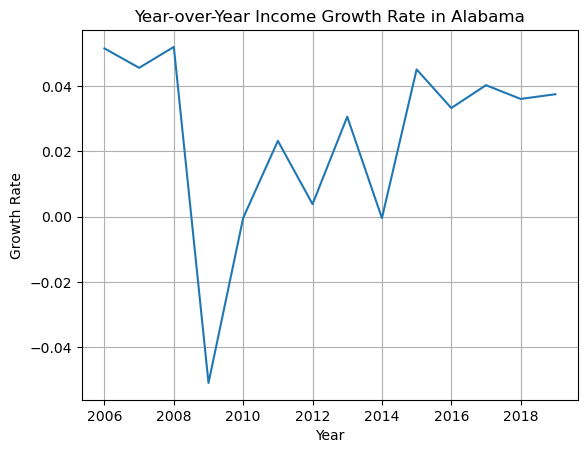

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming al_df as the input DataFrame
al_df = pd.DataFrame({
    'fips': ['01']*15,
    'name': ['Alabama']*15,
    'income': [36879, 38783, 40554, 42666, 40489, 40474, 41415, 41574, 42849, 42830, 44765, 46257, 48123, 49861, 51734],
    'year': list(range(2005, 2020))
})

# Compute the income growth rate
al_df['growth_rate'] = al_df['income'].pct_change()

# Plot the growth rate
plt.plot(al_df['year'], al_df['growth_rate'])
plt.title('Year-over-Year Income Growth Rate in Alabama')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.grid(True)
plt.show()

### The code above creates the graph of the growth rate of Alabama over the time in the sql database. The chart shows a significant drop from 2008 to 2009, but shows significant growth. 

# Q2: Income and Population Relationship 

In [38]:
sql_2 = """
SELECT 
    n.name AS county_name,
    i.year,
    i.income,
    p.pop AS population
FROM 
    income i
JOIN 
    population p 
    ON i.fips = p.fips 
    AND i.year = p.year
JOIN 
    name n 
    ON i.fips = n.fips
WHERE 
    n.name LIKE '%Alabama%'
ORDER BY 
    i.year, n.name
    """

In [39]:
import pandas as pd

al_df2 = pd.read_sql(sql_2, con=conn)
al_df2.head()

,county_name,year,income,population
0,Alabama,2005,36879,4442558
1,Alabama,2006,38783,4599030
2,Alabama,2007,40554,4627851
3,Alabama,2008,42666,4661900
4,Alabama,2009,40489,4708708


In [65]:
%%ai gpt4 -f code
Create a dual-axis chart in Python from {al_df2}, with the X-axis as year, Left Y-axis as population (line), and Right Y-axis as median household income (bar or line, different color) 
The state name, 'Alabama', must be in the title

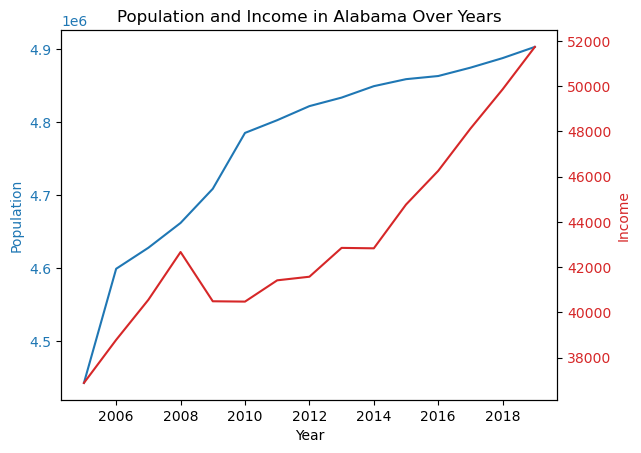

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming that the DataFrame is df
df = pd.DataFrame({
    'county_name': ['Alabama']*15,
    'year': list(range(2005, 2020)),
    'income': [36879, 38783, 40554, 42666, 40489, 40474, 41415, 41574, 42849, 42830, 44765, 46257, 48123, 49861, 51734],
    'population': [4442558, 4599030, 4627851, 4661900, 4708708, 4785298, 4802740, 4822023, 4833722, 4849377, 4858979, 4863300, 4874747, 4887871, 4903185]    
})

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df['year'], df['population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Income', color=color)
ax2.plot(df['year'], df['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Population and Income in Alabama Over Years')
plt.show()

## The population and income trends compare fairly closely in terms of trends. However, there was a significant rise in income around 2008, but soon after a drop in 2009. Additionally, population has never decreased and had a steep climb from 2008-2010.

# Q3: Which 5 years showed the highest population increase in Alabama? 

In [40]:
sql_3 = """
SELECT 
    p1.year AS year,
    (p1.pop - p2.pop) AS population_increase
FROM 
    population p1
JOIN 
    population p2 
    ON p1.fips = p2.fips 
    AND p1.year = p2.year + 1
JOIN 
    name n 
    ON p1.fips = n.fips
WHERE 
    n.name = 'Alabama'
ORDER BY 
    population_increase DESC
LIMIT 5
"""


In [41]:
import pandas as pd

al_df3 = pd.read_sql(sql_3, con=conn)
al_df3.head()

,year,population_increase
0,2006,156472
1,2010,76590
2,2009,46808
3,2008,34049
4,2007,28821


In [42]:
%%ai gpt4 -f code
Create a bar chart in Python from {al_df3}, where each bar is a different color and the state name, 'Alabama', must be in the title

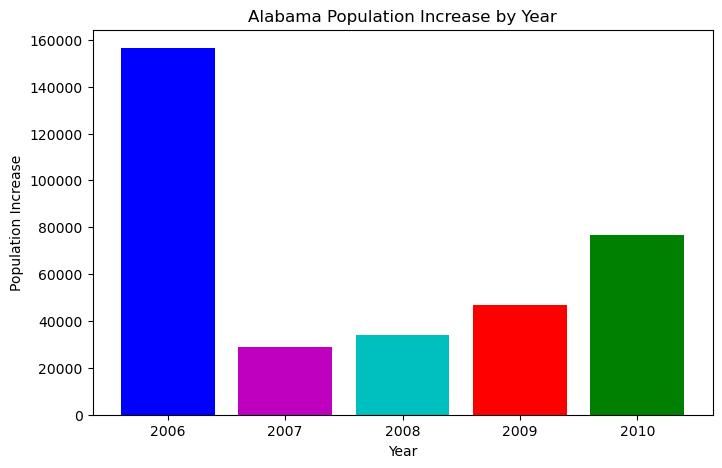

In [43]:
import matplotlib.pyplot as plt

years = [2006, 2010, 2009, 2008, 2007]
population_increase = [156472, 76590, 46808, 34049, 28821]
colors = ['b', 'g', 'r', 'c', 'm']

plt.figure(figsize=(8,5))
plt.bar(years, population_increase, color=colors)
plt.title('Alabama Population Increase by Year')
plt.xlabel('Year')
plt.ylabel('Population Increase')
plt.show()

## This question displays the top 5 years where there was a population increase. Primarily, in 2006 their was a roughly 160,000 population increase from 2005. However, the population would not see an increase close to this again. 